In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import numpy as np
import scipy
from scipy.optimize import curve_fit

#### load data

In [7]:
input_csv = "recording_0.5hzcombias1.csv"

df = pd.read_csv(input_csv, comment='#', names=['x', 'y', 'p', 't'])
df.head()

,x,y,p,t
0,396,557,0,4832
1,392,500,1,4832
2,397,471,1,4832
3,398,549,1,4832
4,391,519,1,4833


### Filter


In [8]:
%matplotlib inline
# Define the parameters
tmin = 1100000
tmax = 1100300
ymin = 466
ymax = 550
xmin = 390
xmax = 392
y = 500

# Filter the DataFrame for the specified horizontal line of pixels
line_df = df[(df['x'] >= xmin) & (df['x'] <= xmax) & (df['y'] >= ymin) & (df['y'] <= ymax)]

# Apply time filtering if specified
if tmin is not None:
    line_df = line_df[line_df['t'] >= tmin]
if tmax is not None:
    line_df = line_df[line_df['t'] <= tmax]

# Check if the filtered DataFrame is empty
if line_df.empty:
    print("No data points found for the given filters.")
else:
    print(f"Number of data points: {len(line_df)}")
    print(line_df)
    print(f"Time range: {line_df['t'].min()} to {line_df['t'].max()}")
    line_df.head()


Number of data points: 278
           x    y  p        t
4114177  392  549  1  1100000
4114178  390  503  1  1100001
4114182  392  502  1  1100001
4114184  392  500  1  1100001
4114189  390  548  1  1100002
...      ...  ... ..      ...
4115647  390  550  1  1100293
4115649  390  475  1  1100294
4115660  391  492  0  1100297
4115662  391  488  0  1100297
4115666  390  525  1  1100300

[278 rows x 4 columns]
Time range: 1100000 to 1100300


### Polarity of a pixel x


Data points being plotted:
           y  p  p_numeric
4114177  549  1          1
4114178  503  1          1
4114182  502  1          1
4114184  500  1          1
4114189  548  1          1
...      ... ..        ...
4115647  550  1          1
4115649  475  1          1
4115660  492  0         -1
4115662  488  0         -1
4115666  525  1          1

[278 rows x 3 columns]


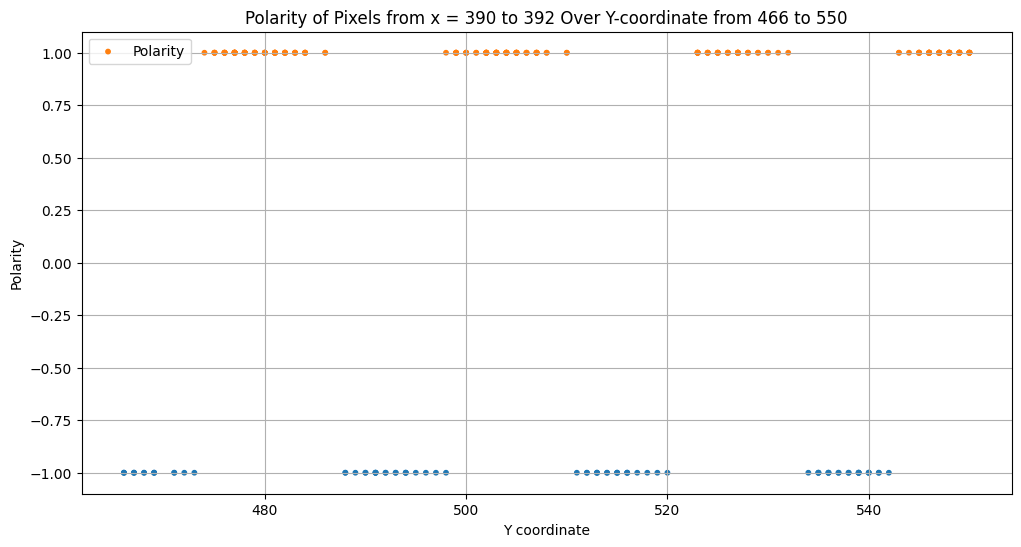

In [9]:

# Define colors for polarity
colors = ["C0", "C1"]
colors_vec = [colors[p] for p in line_df['p']]

# Create `p_numeric` column
line_df['p_numeric'] = line_df['p'].apply(lambda p: 1 if p == 1 else -1)

# Debug: Print the points to be plotted
print("Data points being plotted:")
print(line_df[['y', 'p', 'p_numeric']])

# Plot the polarity as a function of y-coordinate
plt.figure(figsize=(12, 6))
plt.scatter(line_df['y'], line_df['p_numeric'], s=10, c=colors_vec, label='Polarity')

plt.xlabel('Y coordinate')
plt.ylabel('Polarity')
plt.title(f'Polarity of Pixels from x = {xmin} to {xmax} Over Y-coordinate from {ymin} to {ymax}')
plt.legend()
plt.grid(True)
plt.show()



#plt.switch_backend("QtAgg4")
#plt.show()

### Failed attempt of fitting


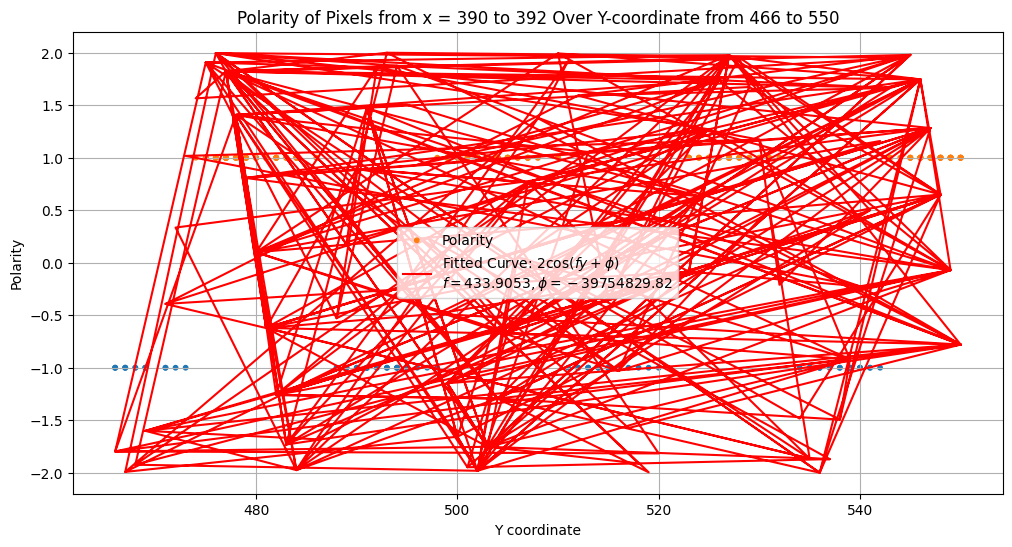

Fitting parameters:
f = 433.90525683990336
phi = -39754829.82120395


In [10]:
# Extract y and p_numeric values
y_values = line_df['y'].values
p_values = line_df['p_numeric'].values

# Perform FFT
fft_result = np.fft.fft(p_values)
fft_freq = np.fft.fftfreq(len(p_values), d=(y_values[1] - y_values[0]))  # Assuming uniform spacing

# Find the dominant frequency
dominant_freq = np.abs(fft_freq[np.argmax(np.abs(fft_result))])

# Define the cosine function to fit
def cosine_function(y, f, phi):
    A = 2  # Fixed amplitude
    return A * np.cos(f * y + phi)

# Initial guess for the parameters [f, phi]
initial_guess = [2 * np.pi * dominant_freq, 0]

# Fit the curve
params, covariance = curve_fit(cosine_function, y_values, p_values, p0=initial_guess)

# Extract the fitting parameters
f, phi = params

# Generate fitted curve
fitted_p = cosine_function(y_values, f, phi)

# Plot the original data and the fitted curve
plt.figure(figsize=(12, 6))
plt.scatter(y_values, p_values, s=10, c=colors_vec, label='Polarity')
plt.plot(y_values, fitted_p, label=f'Fitted Curve: $2 \\cos(fy + \\phi)$\n$f={f:.4f}, \\phi={phi:.2f}$', color='red')

plt.xlabel('Y coordinate')
plt.ylabel('Polarity')
plt.title(f'Polarity of Pixels from x = {xmin} to {xmax} Over Y-coordinate from {ymin} to {ymax}')
plt.legend()
plt.grid(True)
plt.show()

# Debug: Print the fitting parameters
print("Fitting parameters:")
print(f"f = {f}")
print(f"phi = {phi}")


### Function for plotting polarity of individual pixel over a number of pixels

In [11]:
def plot_polarity_individual(df, y_range, x_start, x_end, tmin=1250000, tmax=1500000):
    num_plots = x_end - x_start + 1
    fig, axs = plt.subplots(num_plots, 1, sharex=True, sharey=True, figsize=(12, num_plots * 4))
    
    for i in range(num_plots):
        ax = axs[i] if num_plots > 1 else axs
        pixel_x = x_start + i
        
        # Filter the DataFrame for the specified x-coordinate and y-coordinate range
        pixel_df = df[(df['x'] == pixel_x) & (df['y'] >= y_range[0]) & (df['y'] <= y_range[1])]
        
        # Apply time filtering if specified
        if tmin is not None:
            pixel_df = pixel_df[pixel_df['t'] >= tmin]
        if tmax is not None:
            pixel_df = pixel_df[pixel_df['t'] <= tmax]

        # Convert polarity to 1 or -1 for fitting
        pixel_df['p_numeric'] = pixel_df['p'].apply(lambda p: 1 if p == 1 else -1)
        
        # Define colors for polarity
        colors = ["C0", "C1"]
        colors_vec = [colors[p] for p in pixel_df['p']]
        
        # Plot the polarity as a function of y-coordinate
        ax.scatter(pixel_df['y'], pixel_df['p_numeric'], s=10, c=colors_vec, label=f'Pixel {pixel_x}')
        ax.set_ylabel('Polarity')
        ax.legend()
        ax.grid(True)
    
    plt.xlabel('Y coordinate')
    fig.suptitle(f'Polarity of Individual Pixels Over Y-coordinate {y_range[0]}-{y_range[1]}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()


### Calling the function above

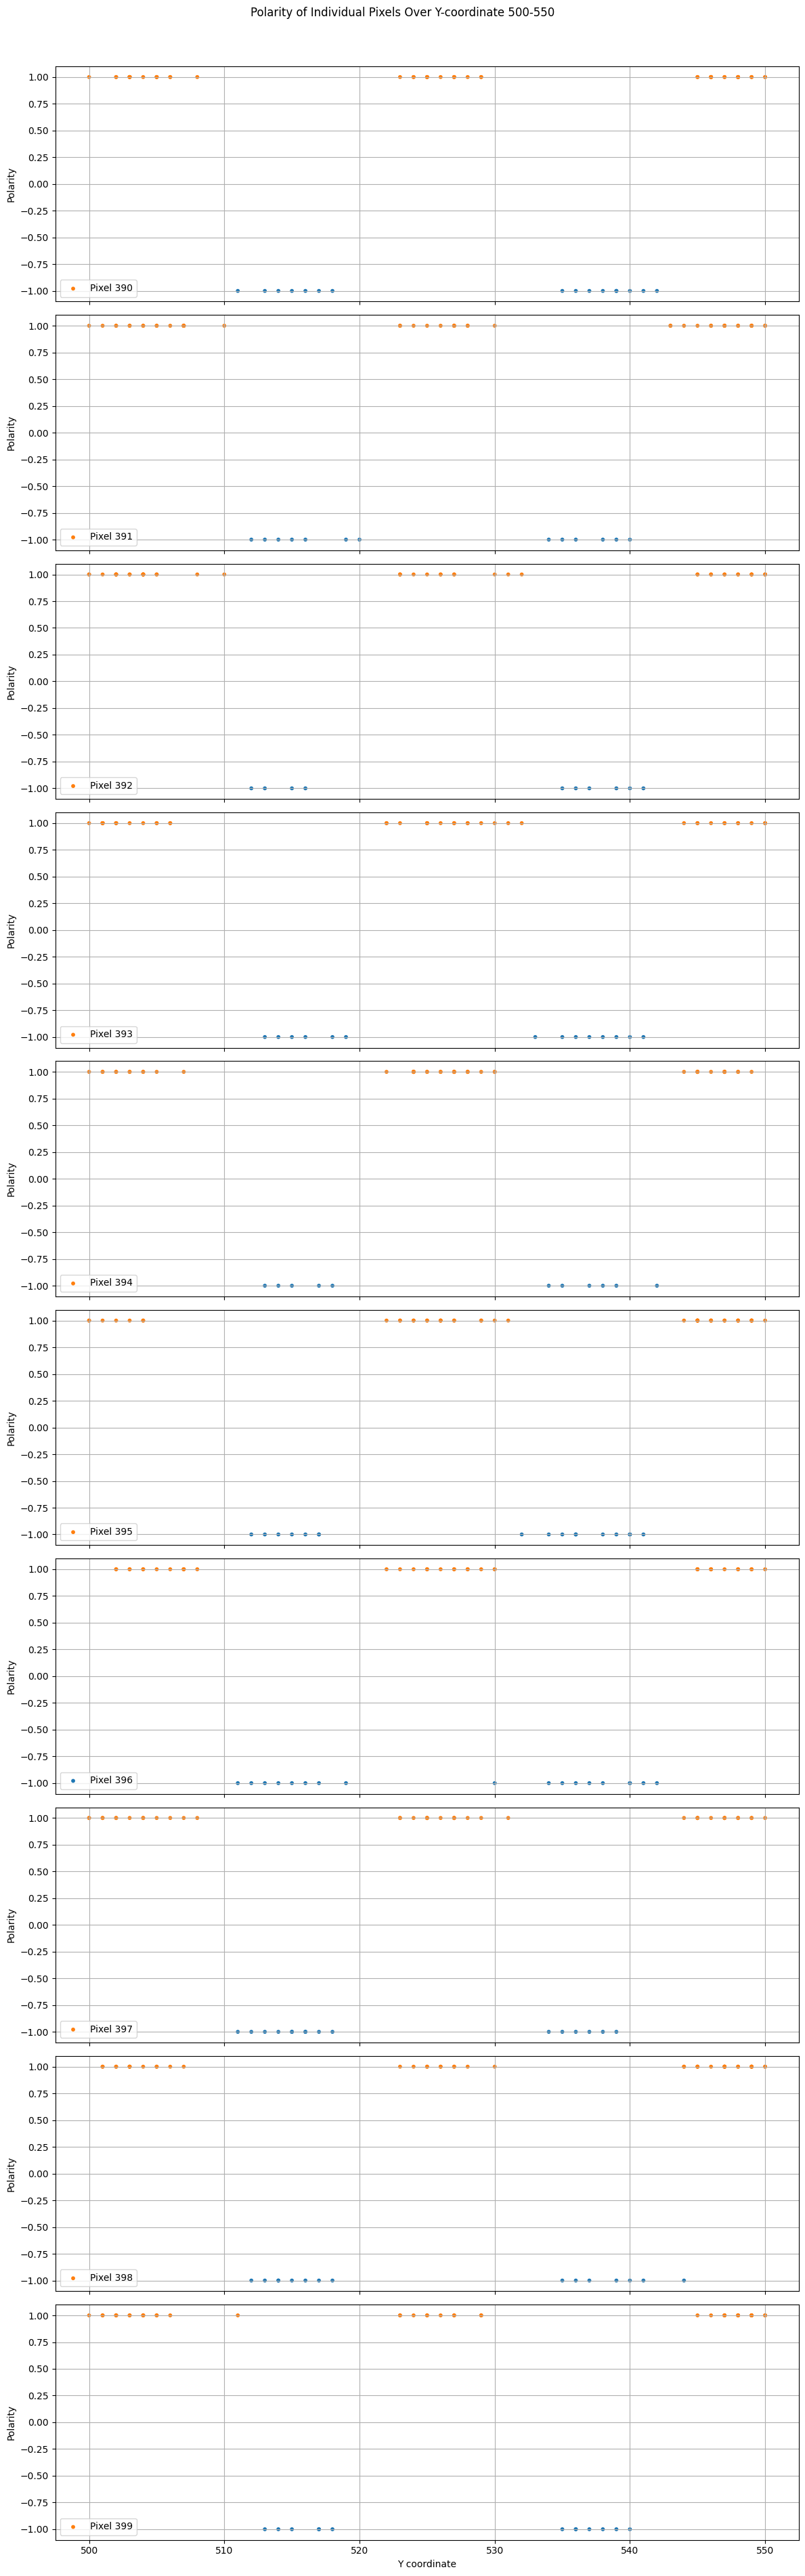

In [12]:
# Define the parameters for plotting individual pixels
ymin = 500
ymax = 550
x_start = 390
x_end = 399  # Adjust this range as needed to cover all your data

# Call the function to plot the polarity graphs
plot_polarity_individual(df, (ymin, ymax), x_start, x_end, tmin, tmax)

In [13]:
# Define the parameters
tmin = 1100000
twindow = 300
tmax = tmin+twindow
ymin = 500
ymax = 550
xmin = 390
xmax = 392
y = 500

# Filter the DataFrame for the specified horizontal line of pixels
line_df = df[(df['x'] >= xmin) & (df['x'] <= xmax) & (df['y'] >= ymin) & (df['y'] <= ymax)]

# Apply time filtering if specified
if tmin is not None:
    line_df = line_df[line_df['t'] >= tmin]
if tmax is not None:
    line_df = line_df[line_df['t'] <= tmax]

# Check if the filtered DataFrame is empty
if line_df.empty:
    print("No data points found for the given filters.")
else:
    print(f"Number of data points: {len(line_df)}")
    print(line_df)
    print(f"Time range: {line_df['t'].min()} to {line_df['t'].max()}")
    line_df.head()

Number of data points: 172
           x    y  p        t
4114177  392  549  1  1100000
4114178  390  503  1  1100001
4114182  392  502  1  1100001
4114184  392  500  1  1100001
4114189  390  548  1  1100002
...      ...  ... ..      ...
4115637  390  505  1  1100291
4115641  392  526  1  1100292
4115646  390  517  0  1100293
4115647  390  550  1  1100293
4115666  390  525  1  1100300

[172 rows x 4 columns]
Time range: 1100000 to 1100300


### plotting individual pixel

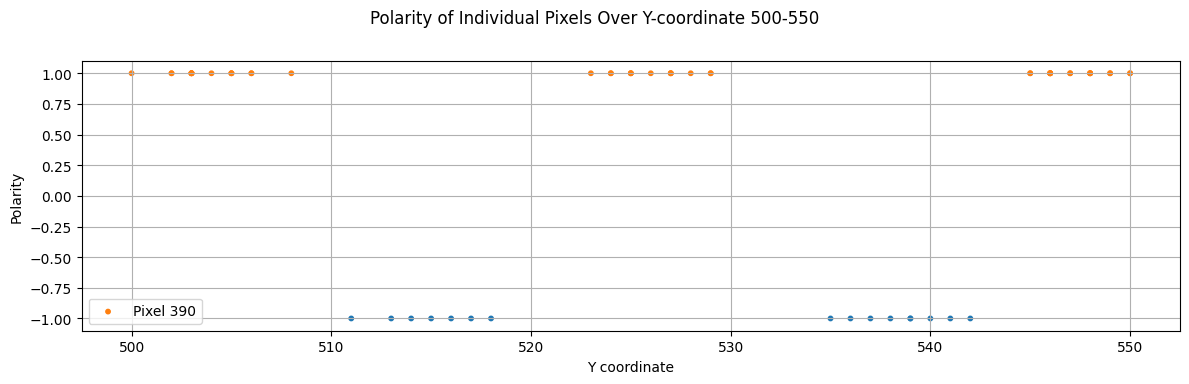

In [14]:
# Define the parameters for plotting individual pixels
ymin = 500
ymax = 550
x_start = 390
x_end = 399  # Adjust this range as needed to cover all your data

# Call the function to plot the polarity graphs
num_plots = x_end - x_start + 1
num_plots = 1
y_range = (ymin, ymax)
fig, axs = plt.subplots(num_plots, 1, sharex=True, sharey=True, figsize=(12, num_plots * 4))

for i in range(num_plots):
    ax = axs[i] if num_plots > 1 else axs
    #ax = axs[0]
    pixel_x = x_start + i
    
    # Filter the DataFrame for the specified x-coordinate and y-coordinate range
    pixel_df = df[(df['x'] == pixel_x) & (df['y'] >= y_range[0]) & (df['y'] <= y_range[1])]
    
    # Apply time filtering if specified
    if tmin is not None:
        pixel_df = pixel_df[pixel_df['t'] >= tmin]
    if tmax is not None:
        pixel_df = pixel_df[pixel_df['t'] <= tmax]

    # Convert polarity to 1 or -1 for fitting
    pixel_df['p_numeric'] = pixel_df['p'].apply(lambda p: 1 if p == 1 else -1)
    
    # Define colors for polarity
    colors = ["C0", "C1"]
    colors_vec = [colors[p] for p in pixel_df['p']]
    
    # Plot the polarity as a function of y-coordinate
    ax.scatter(pixel_df['y'], pixel_df['p_numeric'], s=10, c=colors_vec, label=f'Pixel {pixel_x}')
    ax.set_ylabel('Polarity')
    ax.legend()
    ax.grid(True)

plt.xlabel('Y coordinate')
fig.suptitle(f'Polarity of Individual Pixels Over Y-coordinate {y_range[0]}-{y_range[1]}')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

### interpolation of a polarity of a pixel

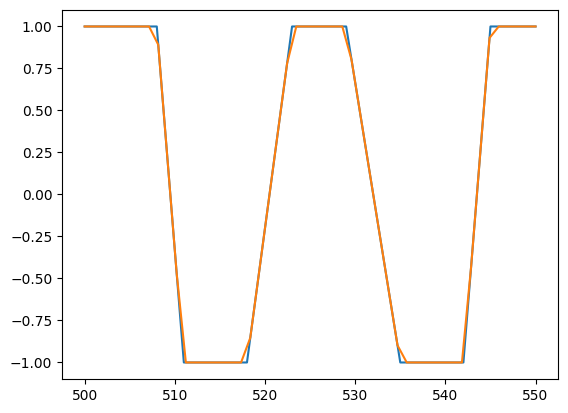

In [15]:

y, p = pixel_df['y'], pixel_df['p_numeric']

idx = np.argsort(y)
y = np.array(y)[idx]
p = np.array(p)[idx]

int_y = np.linspace(ymin, ymax, int(ymax-ymin))
int_p = np.interp(int_y, y,p, )


plt.plot(y, p)
plt.plot(int_y, int_p)

### FFT of polarity (time to frequency) and finding its peak


C:\Users\Pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\signal\_peak_finding.py:266: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


(array([2], dtype=int64), array([-0.21268106]))

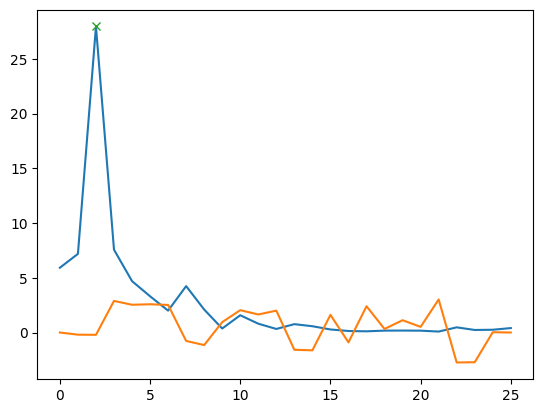

In [16]:
from scipy.signal import find_peaks

ft = np.fft.rfft(int_p)

peaksidx, _ = find_peaks(ft, distance=10, prominence=10)

plt.plot(abs(ft))

plt.plot(np.angle(ft))
plt.plot(peaksidx, abs(ft[peaksidx]), "x")
phase = np.angle(ft[peaksidx])
peaksidx, phase

#### combined moving time window of polarity and finding the peaks of its ffts


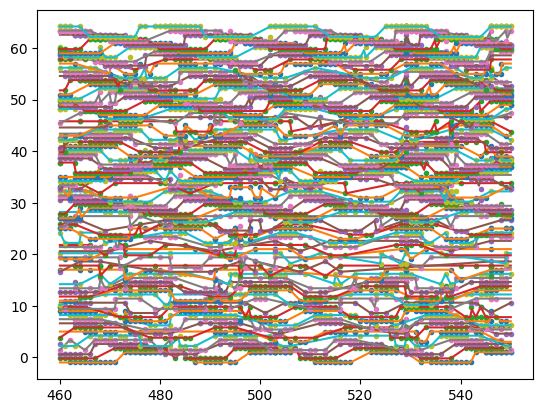

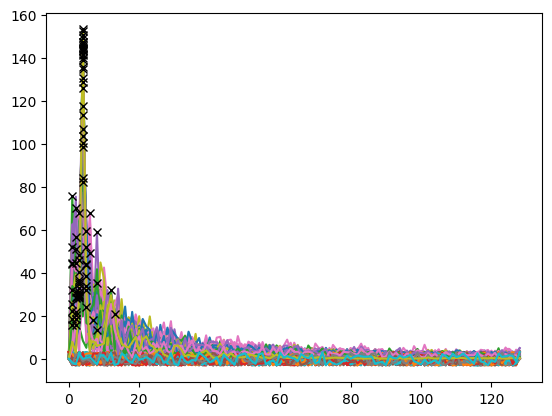

In [17]:
# Define the parameters


ymin = 460
ymax = 550
xmin = 390
xmax = 392
y = 500

t_start = 1100000
t_end = 1150000
t_end = 1110000
t_end = 1140000
t_window = 500
t_step = 500
x_start = 390
x_end = 399  # Adjust this range as needed to cover all your data


phase_vec = []
t_vec = []
for i,tmin in enumerate(list(np.arange(t_start, t_end, t_step))):
    tmax = tmin+t_window

    

    # Filter the DataFrame for the specified horizontal line of pixels
    line_df = df[(df['x'] >= xmin) & (df['x'] <= xmax) & (df['y'] >= ymin) & (df['y'] <= ymax)]

    # Apply time filtering if specified
    if tmin is not None:
        line_df = line_df[line_df['t'] >= tmin]
    if tmax is not None:
        line_df = line_df[line_df['t'] <= tmax]

    # Check if the filtered DataFrame is empty
    if line_df.empty:
        continue
    #   print("No data points found for the given filters.")
    else:
        #print(f"Number of data points: {len(line_df)}")
        #print(line_df)
        #print(f"Time range: {line_df['t'].min()} to {line_df['t'].max()}")
        line_df.head()


  

    # Call the function to plot the polarity graphs

    y_range = (ymin, ymax)
    
    pixel_x = x_start

    # Filter the DataFrame for the specified x-coordinate and y-coordinate range
    pixel_df = df[(df['x'] == pixel_x) & (df['y'] >= y_range[0]) & (df['y'] <= y_range[1])]

    # Apply time filtering if specified
    if tmin is not None:
        pixel_df = pixel_df[pixel_df['t'] >= tmin]
    if tmax is not None:
        pixel_df = pixel_df[pixel_df['t'] <= tmax]

    # Convert polarity to 1 or -1 for fitting
    pixel_df['p_numeric'] = pixel_df['p'].apply(lambda p: 1 if p == 1 else -1)




        
    y, p = pixel_df['y'], pixel_df['p_numeric']

    all_y = np.arange(ymin, ymax+1, 1)
    fringe_vec = np.zeros(len(all_y))

    idx = np.argsort(y)
    y = np.array(y)[idx]
    p = np.array(p)[idx]


    for idx in range(len(y)):
        fringe_vec[y[idx]-ymin] += p[idx]

    all_y, y-ymin,fringe_vec
    
    if 0:
        y = all_y
        p = fringe_vec

    #int_y = np.linspace(ymin, ymax, int(ymax-ymin))
    int_y = np.linspace(ymin, ymax, 256)


    try:
        int_p = np.interp(int_y, y,p, )

    except:
        print("failed",i)
        continue

        
    plt.figure(1)
    offset = i*0.8
    plt.plot(y, p+offset, ".")
    plt.plot(int_y, int_p+offset)

    int_p -= np.mean(int_p)

    ft = np.fft.rfft(int_p)

    #peaksidx, _ = find_peaks(ft, distance=10, prominence=10)
    peaksidx = np.argmax(ft)

    plt.figure(2)
    plt.plot(abs(ft))

    plt.plot(np.angle(ft))
    plt.plot(peaksidx, abs(ft[peaksidx]), "kx", zorder=100)


    phase = np.angle(ft[peaksidx])
    peaksidx, phase

    # if len(phase)==0:
    #     phase = np.nan
    #     continue
    # else:
    #     phase = phase[0]

    t_vec.append(tmin)
    phase_vec.append(phase)


In [193]:
phase_vec

[0.867921898014959,
 1.4292235535822992,
 0.029277602047464553,
 -0.19209907067260365,
 -0.6199226659107232,
 -0.3946254623969573,
 0.45961300488759305,
 -0.3729385956081286,
 -0.3939542183797775,
 -0.3239511103810837,
 -0.17523972135108676,
 -0.07874300641232072,
 -0.6402366328584134,
 0.6867726510020656,
 0.059945865211072154,
 0.5085615554180118,
 1.2590603509039269,
 1.403880960402838,
 1.1465859838388255,
 0.9124482247659348,
 -0.028299941014656473,
 -0.03806757406694089,
 0.2961283204384169,
 -0.5532113376624349,
 -0.7013761810052485,
 -0.35141563752498717,
 -0.35611046522295914,
 1.1124207077532198,
 0.536808731961772,
 0.07410133893362955,
 -0.0018825793011482803,
 -0.8270968538349048,
 -0.49224734973976547,
 0.5373022058587784,
 -0.02289891376334268,
 -1.044078199929328,
 0.2119849523513982,
 -0.2322553855881242,
 -1.1157804565824558,
 -0.9301223878718743]

### plot of phase over time


array([ 0.56130166, -0.41932215, -0.81066131, -0.32460013, -0.1012632 ,
        0.53976784,  0.01084343, -0.42678361,  0.02449374,  0.10935725,
        0.12260405, -0.23249846,  0.38275783,  0.35009125, -0.08910555,
        0.59955724,  0.4476597 , -0.05623718, -0.24571637, -0.58744296,
       -0.4752579 ,  0.16221413, -0.25757188, -0.49875225,  0.10089785,
        0.17263286,  0.73191817,  0.4464596 , -0.51915968, -0.26934566,
       -0.4505991 , -0.24518239,  0.68219953,  0.23467422, -0.7906902 ,
        0.11744193,  0.40591141, -0.6638827 , -0.3489335 ,  0.19835711,
        0.79675507,  0.62671957, -0.70172061, -0.36072352,  0.88276409,
        0.18628055, -0.81686541, -0.61660181,  0.19034782,  0.4346924 ,
       -0.13715984,  0.40240187,  0.10222793, -0.1220307 , -0.09296413,
       -0.58258511,  0.62486153,  0.19026919, -0.86879972, -0.1191307 ,
        0.48674789,  0.73982043,  0.65125974, -0.66505321, -0.91984315,
        0.16858128,  0.27260384, -0.18310293, -0.13023713,  0.46

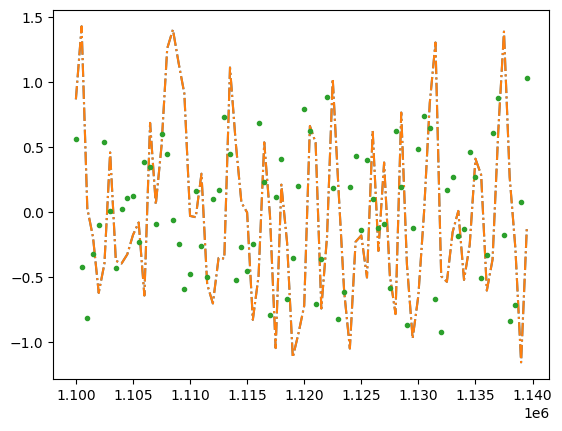

In [18]:
unwrap = np.unwrap(phase_vec)
plt.plot(t_vec, phase_vec,'-.')
plt.plot(t_vec, unwrap,'-.')

phase_diff = np.gradient(unwrap)
t_vec, phase_vec
plt.plot(t_vec, phase_diff,'.')

phase_diff 

### Plot of distance over time

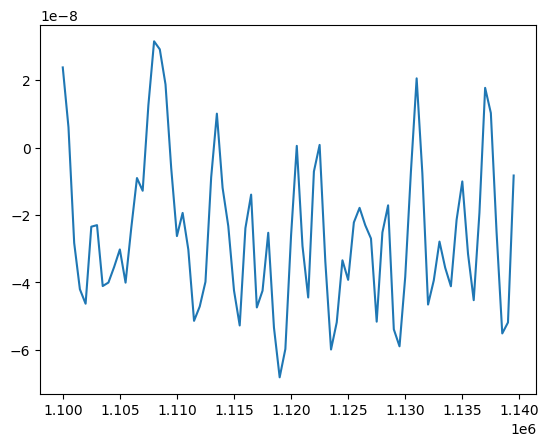

In [19]:
phase_accum = np.nancumsum(phase_diff)
wavelength = 532e-9
distance = phase_accum/(2*np.pi)*wavelength/2

plt.plot(t_vec, distance)

### another plot of distance over time but with a larger window

array([    4.1887902 ,     5.02654825,     5.44542727, ...,
       -1007.82292327, -1008.24180229, -1009.49843935])

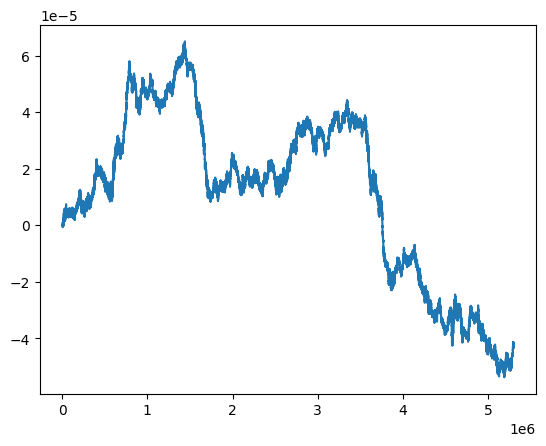

In [226]:
# Define the parameters


ymin = 490
ymax = 505
xmin = 390
xmax = 392
y = 500

t_start = 1100000
t_end = 1150000
t_end = 1110000
t_end = 1140000
t_window = 500
t_step = 500
x_start = 390
x_end = 399  # Adjust this range as needed to cover all your data




    # Filter the DataFrame for the specified horizontal line of pixels
line_df = df[(df['x'] >= xmin) & (df['x'] <= xmax) & (df['y'] >= ymin) & (df['y'] <= ymax)]

t = line_df['t']
phase = (line_df['y']-ymin)/(ymax-ymin)*2*np.pi
phase = (line_df['y']-ymin)/(ymax-ymin)*2*np.pi

phase = np.unwrap(phase)

#phase = np.gradient(phase)

distance = phase/(2*np.pi)*wavelength/2

plt.plot(t,distance)
phase

### test


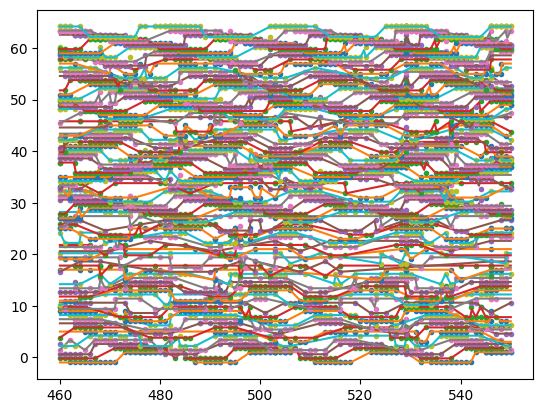

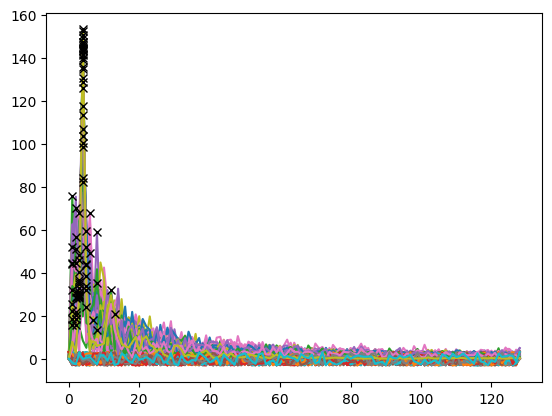

In [20]:

phase_vec = []
t_vec = []
for i,tmin in enumerate(list(np.arange(t_start, t_end, t_step))):
    tmax = tmin+t_window

    

    # Filter the DataFrame for the specified horizontal line of pixels
    line_df = df[(df['x'] >= xmin) & (df['x'] <= xmax) & (df['y'] >= ymin) & (df['y'] <= ymax)]

    # Apply time filtering if specified
    if tmin is not None:
        line_df = line_df[line_df['t'] >= tmin]
    if tmax is not None:
        line_df = line_df[line_df['t'] <= tmax]

    # Check if the filtered DataFrame is empty
    if line_df.empty:
        continue
    #   print("No data points found for the given filters.")
    else:
        #print(f"Number of data points: {len(line_df)}")
        #print(line_df)
        #print(f"Time range: {line_df['t'].min()} to {line_df['t'].max()}")
        line_df.head()


  

    # Call the function to plot the polarity graphs

    y_range = (ymin, ymax)
    
    pixel_x = x_start

    # Filter the DataFrame for the specified x-coordinate and y-coordinate range
    pixel_df = df[(df['x'] == pixel_x) & (df['y'] >= y_range[0]) & (df['y'] <= y_range[1])]

    # Apply time filtering if specified
    if tmin is not None:
        pixel_df = pixel_df[pixel_df['t'] >= tmin]
    if tmax is not None:
        pixel_df = pixel_df[pixel_df['t'] <= tmax]

    # Convert polarity to 1 or -1 for fitting
    pixel_df['p_numeric'] = pixel_df['p'].apply(lambda p: 1 if p == 1 else -1)




        
    y, p = pixel_df['y'], pixel_df['p_numeric']

    all_y = np.arange(ymin, ymax+1, 1)
    fringe_vec = np.zeros(len(all_y))

    idx = np.argsort(y)
    y = np.array(y)[idx]
    p = np.array(p)[idx]


    for idx in range(len(y)):
        fringe_vec[y[idx]-ymin] += p[idx]

    all_y, y-ymin,fringe_vec
    
    if 0:
        y = all_y
        p = fringe_vec

    #int_y = np.linspace(ymin, ymax, int(ymax-ymin))
    int_y = np.linspace(ymin, ymax, 256)


    try:
        int_p = np.interp(int_y, y,p, )

    except:
        print("failed",i)
        continue

        
    plt.figure(1)
    offset = i*0.8
    plt.plot(y, p+offset, ".")
    plt.plot(int_y, int_p+offset)

    int_p -= np.mean(int_p)

    ft = np.fft.rfft(int_p)

    #peaksidx, _ = find_peaks(ft, distance=10, prominence=10)
    peaksidx = np.argmax(ft)

    plt.figure(2)
    plt.plot(abs(ft))

    plt.plot(np.angle(ft))
    plt.plot(peaksidx, abs(ft[peaksidx]), "kx", zorder=100)


    phase = np.angle(ft[peaksidx])
    peaksidx, phase

    # if len(phase)==0:
    #     phase = np.nan
    #     continue
    # else:
    #     phase = phase[0]

    t_vec.append(tmin)
    phase_vec.append(phase)


C:\Users\Pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\signal\_peak_finding.py:266: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


(array([ 4, 21], dtype=int64), array([-0.12377386, -0.03832724]))

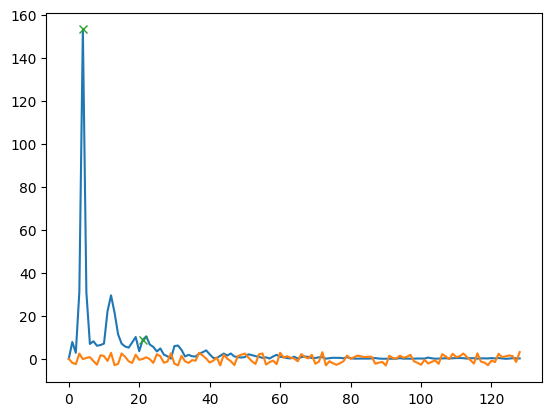

In [21]:
from scipy.signal import find_peaks

ft = np.fft.rfft(int_p)

peaksidx, _ = find_peaks(ft, distance=10, prominence=10)

plt.plot(abs(ft))

plt.plot(np.angle(ft))
plt.plot(peaksidx, abs(ft[peaksidx]), "x")
phase = np.angle(ft[peaksidx])
peaksidx, phase

C:\Users\Pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\signal\_peak_finding.py:266: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)
C:\Users\Pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\signal\_peak_finding.py:266: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)
C:\Users\Pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\signal\_peak_finding.py:266: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)
C:\Users\Pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\

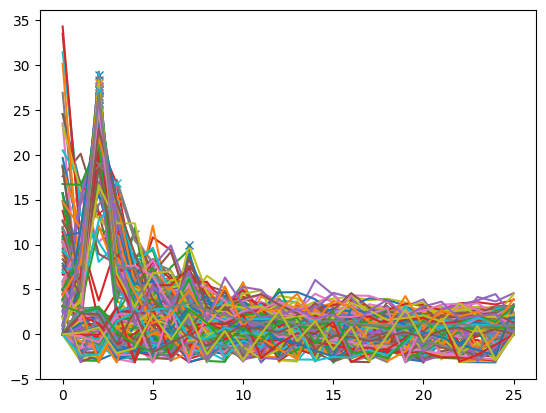

In [22]:
# Define the parameters


ymin = 500
ymax = 550
xmin = 390
xmax = 392
y = 500

t_start = 1100000
t_end = 1150000
t_window = 500
t_step = 500
x_start = 390
x_end = 399  # Adjust this range as needed to cover all your data


phase_vec = []
t_vec = []
for tmin in list(np.arange(t_start, t_end, t_step)):
    tmax = tmin+t_window

    

    # Filter the DataFrame for the specified horizontal line of pixels
    line_df = df[(df['x'] >= xmin) & (df['x'] <= xmax) & (df['y'] >= ymin) & (df['y'] <= ymax)]

    # Apply time filtering if specified
    if tmin is not None:
        line_df = line_df[line_df['t'] >= tmin]
    if tmax is not None:
        line_df = line_df[line_df['t'] <= tmax]

    # Check if the filtered DataFrame is empty
    if line_df.empty:
        continue
    #   print("No data points found for the given filters.")
    else:
        #print(f"Number of data points: {len(line_df)}")
        #print(line_df)
        #print(f"Time range: {line_df['t'].min()} to {line_df['t'].max()}")
        line_df.head()


  

    # Call the function to plot the polarity graphs

    y_range = (ymin, ymax)
    
    pixel_x = x_start

    # Filter the DataFrame for the specified x-coordinate and y-coordinate range
    pixel_df = df[(df['x'] == pixel_x) & (df['y'] >= y_range[0]) & (df['y'] <= y_range[1])]

    # Apply time filtering if specified
    if tmin is not None:
        pixel_df = pixel_df[pixel_df['t'] >= tmin]
    if tmax is not None:
        pixel_df = pixel_df[pixel_df['t'] <= tmax]

    # Convert polarity to 1 or -1 for fitting
    pixel_df['p_numeric'] = pixel_df['p'].apply(lambda p: 1 if p == 1 else -1)




    y, p = pixel_df['y'], pixel_df['p_numeric']

    idx = np.argsort(y)
    y = np.array(y)[idx]
    p = np.array(p)[idx]

    int_y = np.linspace(ymin, ymax, int(ymax-ymin))


    try:
        int_p = np.interp(int_y, y,p, )

    except:
        continue


    #plt.plot(y, p)
    #plt.plot(int_y, int_p)



    ft = np.fft.rfft(int_p)

    peaksidx, _ = find_peaks(ft, distance=10, prominence=10)

    plt.plot(abs(ft))

    plt.plot(np.angle(ft))
    plt.plot(peaksidx, abs(ft[peaksidx]), "x")
    phase = np.angle(ft[peaksidx])
    peaksidx, phase

    if len(phase)==0:
        phase = np.nan
        continue
    else:
        phase = phase[0]

    t_vec.append(tmin)
    phase_vec.append(phase)


### cluster formation

###